# This file use SCNN network for image classification

### Some pre-settings

In [1]:
"""
some pre-settings to ensure the functioning of my GPU flatiom
remove if not needed
"""
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)


### Build a model which employ FC head, keep in mind the number of parameters which should be the same as our FCN network.

In [2]:
# model
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Activation, SeparableConv2D

Using TensorFlow backend.


In [3]:
"""
Using SeparableConv2D instead of Conv2D
the number of parameters is quit small
"""
model = Sequential()
model.add(SeparableConv2D(32, (3, 3), activation='relu', input_shape=[28, 28, 1]))
model.add(SeparableConv2D(32, (3, 3), activation='relu'))
model.add(SeparableConv2D(32, (3, 3), activation='relu'))
model.add(SeparableConv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(SeparableConv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(SeparableConv2D(10, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(10, activation='softmax'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d_1 (Separabl (None, 26, 26, 32)        73        
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 24, 24, 32)        1344      
_________________________________________________________________
separable_conv2d_3 (Separabl (None, 22, 22, 32)        1344      
_________________________________________________________________
separable_conv2d_4 (Separabl (None, 20, 20, 32)        1344      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 32)        0         
_________________________________________________________________
separable_conv2d_5 (Separabl (None, 8, 8, 64)          2400      
_________________________________________________________________
max_

### Data preprocessing 

In [4]:
"""
view the shape of dataset
"""
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
print('x_train.shape: ', x_train.shape)
print('y_train.shape: ', y_train.shape)
print('x_test.shape: ', x_test.shape)
print('y_test.shape: ', y_test.shape)

x_train.shape:  (60000, 28, 28)
y_train.shape:  (60000,)
x_test.shape:  (10000, 28, 28)
y_test.shape:  (10000,)


In [5]:
"""
uncomment because we use a RTX2060 GPU for training.
If the dataset is too large for your system, for example you use CPU to train, you can sample only part of the data.
And print the sample size
"""
# x_train = x_train[:1000]
# y_train = y_train[:1000]
# x_test  = x_test[:100]
# y_test  = y_test[:100]

# print('After downsampling: ')
# print('x_train.shape: ', x_train.shape)
# print('y_train.shape: ', y_train.shape)
# print('x_test.shape: ', x_test.shape)
# print('y_test.shape: ', y_test.shape)

'\nuncomment because we use a RTX2060 GPU for training.\nIf the dataset is too large for your system, for example you use CPU to train, you can sample only part of the data.\nAnd print the sample size\n'

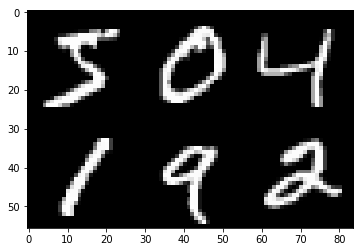

In [6]:
"""
visualize the data
"""
import matplotlib.pyplot as plt
import numpy as np

image1 = np.concatenate((x_train[0], x_train[1], x_train[2]), axis=1)
image2 = np.concatenate((x_train[3], x_train[4], x_train[5]), axis=1)
image = np.concatenate((image1, image2), axis=0)
plt.imshow(image, cmap='gray')
plt.show()

In [7]:
"""
pre-processing and show show the shape of data
"""
print('check the maximum value in the image:', np.max(x_train[0]))
print('check data type:', type(x_train[0,0,0]))

x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test  = x_test.reshape((x_test.shape[0], 28, 28, 1))

x_train = x_train.astype('float32')
x_test  = x_test.astype('float32')
x_train /= 255
x_test /= 255

# print('check labels:', y_train[:10])
y_train = keras.utils.to_categorical(y_train, 10)
y_test  = keras.utils.to_categorical(y_test, 10)
# print('check label shape:', y_train.shape)
# print('check labels:', y_train[:10])

check the maximum value in the image: 255
check data type: <class 'numpy.uint8'>


In [8]:
"""
settings for training
"""
model.compile(optimizer=keras.optimizers.RMSprop(),
              loss=keras.losses.categorical_crossentropy,
              metrics=[keras.metrics.categorical_accuracy])

call_back_list = [
    keras.callbacks.EarlyStopping(monitor = 'categorical_accuracy',
                                  patience = 3),
    
    keras.callbacks.ModelCheckpoint(filepath='mnist-fc.h5', 
                                    monitor='val_loss', 
                                    save_best_only=True)
                 ]

In [9]:
"""
train a SCNN + FC model
"""
history = model.fit(x_train, y_train,
          batch_size=64,
          epochs=500,
          validation_data=(x_test, y_test),
          callbacks=call_back_list)

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/500
60000/60000 [==============================] - 11s 179us/step - loss: 0.8811 - categorical_accuracy: 0.7054 - val_loss: 0.4919 - val_categorical_accuracy: 0.8336
Epoch 2/500
60000/60000 [==============================] - 9s 146us/step - loss: 0.2563 - categorical_accuracy: 0.9232 - val_loss: 0.1998 - val_categorical_accuracy: 0.9372
Epoch 3/500
60000/60000 [==============================] - 9s 147us/step - loss: 0.1775 - categorical_accuracy: 0.9463 - val_loss: 0.1431 - val_categorical_accuracy: 0.9553
Epoch 4/500
60000/60000 [==============================] - 9s 146us/step - loss: 0.1426 - categorical_accuracy: 0.9566 - val_loss: 0.1373 - val_categorical_accuracy: 0.9584
Epoch 5/500
60000/60000 [==============================] - 9s 146us/step - loss: 0.1187 - categorical_accuracy: 0.9637 - val_loss: 0.1433 - val_categorical_accuracy: 0.9546
Epoch 6/500
60000/60000 [===========

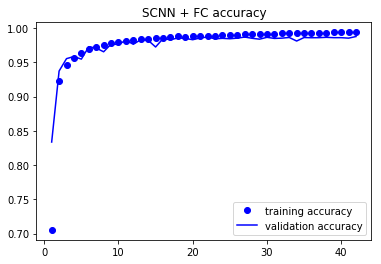

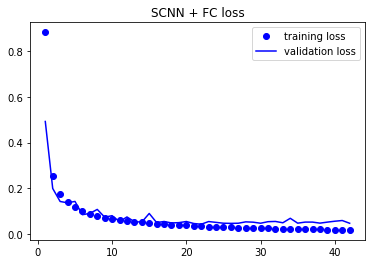

In [10]:
"""
visualize the results
"""
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='training accuracy')
plt.plot(epochs, val_acc, 'b', label='validation accuracy')
plt.title('SCNN + FC accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('SCNN + FC loss')
plt.legend()

plt.show()